# Oizumi Model

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from neural import Model
from neural.plot import plot_multiple
from neural.utils import compute_psth, generate_spike_from_psth, generate_stimulus

## Define Oizumi Model

In [2]:
class Oizumi(Model):
    Default_Inters = {'p': 0., 'NT':0}
    Default_States = {'N': (51., 0., 51.), 'g': (0., 0., 1000.)}
    Default_Params = {'N0': 51, 'q': 1.07, 'tauO': 10, 'tauN0': 100, 'pmax': 0.79, 'Kpre': 0.0035}
    
    def ode(self, input=0, f=0.):
        """
        Arguments:
            input (bool): spike indicator.
            f (float): overall spike rate.
        """
        self.p = self.pmax * np.exp(-self.Kpre * f)
        self.d_N = (self.N0 - self.N) / self.tauN0
        self.d_g = -self.g / self.tauO
        
        if input == 1:
            self.NT = self.N*self.p
            self.g += self.NT*self.q
            self.N -= self.NT
        else:
            self.NT = 0

    def get_conductance(self):
        return self.g

## Simulate Oizumi Model with a Spike Train with Step PSTH

We firt synthesize 50 3-second long spike trains that have a PSTH with constant 100 Hz rate between 0.5 and 2.5 second.

In [3]:
dt  = 1e-4
dur = 3.
num = 50

waveform = generate_stimulus('step', dt, dur-dt/2, (0.5, 2.5), 100.)
spikes = generate_spike_from_psth(dt, waveform, num=num)
t = np.arange(0, len(waveform)*dt-dt/2, dt)

Verify the PSTH of th spike train is indeed a step function at 100 Hz.

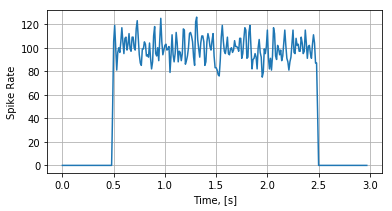

In [4]:
rate, bins = compute_psth(spikes, dt, 20e-3, 10e-3)
plt.figure(figsize=(6,3))
plt.plot(bins, rate)
plt.xlabel('Time, [s]')
plt.ylabel('Spike Rate')
plt.grid()

Simulate 50 Oizumi models with the synthesized spike trains.

In [ ]:
record = {key:np.zeros((num, len(waveform))) for key in ('p','N','NT','g')}

for i, spike in enumerate(spikes):
    oizumi = Oizumi()               
    for j, (spk, wav) in enumerate(zip(spike, waveform)):
        oizumi.update(dt*1e3, input=spk, f=wav)
        for key in record:
            record[key][i][j] = getattr(oizumi, key)

#### Analyze and Plot the Output of the Oizumi Models

In [ ]:
def lpf(dt, sti, freq):
    f = np.fft.fft(sti)
    df = 1./dt/len(sti)
    cut = int(freq//df)
    
    f[cut+1:-cut] = 0
    f *= len(f)*dt
    lpf_sti = np.real(np.fft.ifft(f))
    return lpf_sti

# filter the mean of NT
nt_sum = np.sum(record['NT'], axis=0)
nt_sum_lpf = lpf(dt, nt_sum, 50)

g_mean = np.mean(record['g'], axis=0)

Plot the simulation result.

In [ ]:
fig, axes = plot_multiple(
    t,
    (record['p'][0], {'ylabel':'p', 'ylim':(0,1)}),
    (record['N'][0], {'ylabel':'N'}),
    (record['NT'][0], {'ylabel':'NT','label':'[NT]'},
     nt_sum_lpf, {'label':'LPF(NT)', 'color':'b'}),
    (record['g'][0], {'ylabel':'g','label':'g'},
     g_mean, {'label':'mean(g)', 'color':'b'}),
    color='r',
    xlim=(0,3),
    figw=8,
    figh=3
)